A persons writing style is an example of behaviour biometric. The words people may use and the way they strcuture their scentacnes is distinctive and can often be used to identify the author of a particular work. 

In this project I aim to compare two economists and classify who is the primary author of an academic paper based off their language. 

To ensure a large corpus, I will use Selinium to scrape Google Scholar, one of the most used academic search engines in the world. 

In [5]:
from selenium import webdriver
import requests
from tqdm import tqdm_notebook as tqdm
import time
import random

In [6]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver import ActionChains

In [1]:
import csv
import glob
import os
import sys

In [2]:
from tika import parser

In [3]:
import numpy as np
import pandas as pd

In [4]:
import textacy
import spacy
import re
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [5]:
from sklearn.base import TransformerMixin

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [8]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [9]:
from gensim.models import Word2Vec
import gensim

In [10]:
from sklearn.manifold import TSNE

In [11]:
import matplotlib.pyplot as plt

In [12]:
from sklearn.decomposition import PCA

# Collect and download pdfs from google scholar

Main caveats of google scholar: 
- Cannot perform large scale analysis due to CAPTCHAS (robots) 
- Google scholar search enginge includes mentions of prof as well as author. 

In [8]:
def open_and_search(prof, sleep, directory):

    options = webdriver.ChromeOptions()
    options.add_experimental_option('prefs', {
    "download.default_directory": directory, #Change default directory for downloads
    "download.prompt_for_download": False, #To auto download the file
    "download.directory_upgrade": True,
    "plugins.always_open_pdf_externally": True, #It will not show PDF directly in chrome
    "plugins.extensions_to_open": "" 
    }) 
    
    driver = webdriver.Chrome('/Users/ellafranks/Downloads/chromedriver', options=options)
    driver.get('https://scholar.google.com/')
    time.sleep(sleep)

    driver.find_element_by_id('gs_hdr_tsi').send_keys(prof)

    driver.find_element_by_name('btnG').click()

    time.sleep(sleep)
    
    return driver 

In [9]:
def click_citation(driver, prof):
    time.sleep(1)
    driver.get("https://scholar.google.com/scholar?as_vis=1&q={}&hl=en&as_sdt=0,5".format(prof))
    return driver

In [10]:
def download_pdf(driver, sleep, num_pages, prof, name):
    
    for i in [i*10 for i in range(num_pages)]: 
  
        driver.get('https://scholar.google.com/scholar?start={}&q={}&hl=en&as_sdt=0,5&as_vis=1'.format(i, prof))

        time.sleep(1)

        blocks = driver.find_elements_by_class_name('gs_r.gs_or.gs_scl')

        for block in blocks:
            try: 
                if block.find_element_by_class_name('gs_or_ggsm'):
                    if name in block.find_element_by_class_name('gs_a').text:
                        block.find_element_by_class_name('gs_ctg2').click()
            except:
                pass


**This next line of code is made up of 3 functions:**

1. Navigate to google scholar page, search up associated prof name
2. Apply filters ensuring prof is a key author and not just a citation
3. Download papers that are pdf formatted AND associated prof name as primary author into chosen directory 

These two prof were chosen due to them having written papers with similar content, but never coauthoring a paper together.

In [11]:
directory1 = "/Users/ellafranks/Desktop/Other-projects/Guess_the_prof/Julian_Franks_papers/"
directory2 = "/Users/ellafranks/Desktop/Other-projects/Guess_the_prof/La_Porta_papers/"

In [13]:
#Prof 1 - Julian Franks
download_pdf(click_citation(open_and_search('Julian Franks', 1, directory1), 'Julian+Franks'), 1, 20, 'Julian+Franks', 'Franks')

In [410]:
#Prof 2 - Rafael La Porta
download_pdf(click_citation(open_and_search('La Porta', 1, directory2), 'La+Porta'), 1, 20, 'La+Porta', 'Porta')

# Parse and convert pdf to raw text

Using Tika to extract content from pdfs (need to install the latest version of Java in order to run the script - Can use pdfMiner3 or pdfPlumber if not)

In [22]:
def grab_pdf_content(filepath):
    
    list_pdf, input_files = [], []
    
    #grab all PDF's file name and strip out .pdf
    all_files = glob.glob(os.path.join(filepath, "*.pdf"))
    for input_file in all_files:
        filename = os.path.basename(input_file)
        filename = filename.strip('.pdf')
        
    # Use Tika to parse the PDF's, extract text content
        parsedPDF = parser.from_file(input_file)
        pdf = parsedPDF["content"]
        
        list_pdf.append(pdf)
        input_files.append(filename)
 
    return input_files, list_pdf

In [23]:
def convert_to_df(n, c): 
    corpus = list(zip(n, c))
    df = pd.DataFrame.from_dict({name:doc for name,doc in corpus}, orient='index', columns=['text'])
    df.to_csv('{}_pdfs_df.csv'.format(df.shape[0]))

In [411]:
filepath = "/../Users/ellafranks/Desktop/Other-projects/Guess_the_prof/Julian_Franks_papers"
filepath2 = "/../Users/ellafranks/Desktop/Other-projects/Guess_the_prof/La_Porta_papers"

1. Extract filename and content from Julian Franks
2. Compile and save pdfs into a csv dataframe 
3. Add relevent column (prof) and combine dataframes

In [197]:
# Julian Franks
name, content = grab_pdf_content(filepath)
convert_to_df(name, content)

In [412]:
# La Porta
name2, content2 = grab_pdf_content(filepath2)
convert_to_df(name2, content2)

In [13]:
JF = pd.read_csv('38_pdfs_df.csv', sep=',', index_col=[0])
LP = pd.read_csv('59_pdfs_df.csv', sep=',', index_col=[0])

In [14]:
JF['prof'] = 'Julian'
LP['prof'] = 'Rafael'

In [15]:
comb = pd.concat([JF, LP])
comb.shape

(97, 2)

# Clean and prepare text

In [16]:
def general_clean(content):
    paragraphs = str(content).split('\n\n')
    list_stripped = []  
    for item in paragraphs:
        stripped = item.strip().replace(',', '').lower()
        list_stripped.append(stripped)
    
    #remove if empty cell or paragraph break 
    final_list = []
    for l in list_stripped:
        if l != '' and '\n' not in l:
            final_list.append(l)  
    return final_list

Above I split the content by newline paragraphs, strip them and convert to lowercase and then remove the cell if empty or contains a paragraph break. I then 'explode' the list of lists per row into many rows.

In [17]:
comb.text = comb.text.apply(lambda x: general_clean(x))

In [18]:
df = comb.explode('text')

In [19]:
print('There are {} duplictates found in {} rows.'.format(df.duplicated().sum(), df.shape[0]))

There are 10001 duplictates found in 49564 rows.


I have a very large corpus and in order to make this clean as applicable to all pdfs and their authors, I drop duplicate cells which mostly contain page numbers and chapter references. 

In [20]:
df.drop_duplicates(inplace=True)

In [21]:
print('I will drop {} rows which are less than 10 words long.'.format(df.text.apply(lambda x: len(x.split(' ')) < 10).sum()))

I will drop 13438 rows which are less than 10 words long.


In [22]:
df = df[df['text'].apply(lambda x: len(x.split(' ')) > 10)]

In [23]:
df = df.reset_index().rename(columns={'index': 'paper'})

Remove all occurances of prof name and all instances where cells begin with an asterix as they tend to be footnotes 

In [24]:
prof = 'Julian|Franks|Rafael|Porta|La'

print('There are {} number of instances of the prof name, so we shall replace these.'.\
      format(df[df['text'].str.contains(prof, flags=re.IGNORECASE)].shape[0]))

There are 6924 number of instances of the prof name, so we shall replace these.


In [25]:
prof = ['julian', 'franks', 'rafael', 'porta', 'la']
df.text = df.text.replace({l: '' for l in prof}, regex=True)

In [26]:
df = df[df.text.map(lambda x: not (x.startswith('*')))]

We would ideally like the classes as balenced as possible

In [27]:
df.groupby('prof')[['text']].count()

,text
prof,
Julian,15311
Rafael,9166


# Process text using spacy and make predictions

**Build a classification model to predict if the economics paper was Julian Franks or La Porta**

In [28]:
df['prof'].value_counts(normalize=True).max()

0.6255260040037587

***Aim is to differentiate language pertaining to economics, rather than places, people, references or common words.***

**I will now create a tokenizer function that returns a list of preproccessed tokens that will have:**
- Named entities (people and places removed)
- Lowercased
- Lemmatised
- Stop words and punctuation removed.

**Also use a custom transformer that uses spaCy**

In [29]:
#load small pretrained model as parser trained on written web text
parser = spacy.load('en_core_web_sm')
stop_words = STOP_WORDS
punctuations = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word for word in mytokens if not word.ent_type]  
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic function to remove any instances of punctuation found between letters 
def clean_text(text):
    return ''.join(ch for ch in text if ch not in punctuations)

In [90]:
X = df['text']
y = df['prof'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

In [91]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, max_features=5000, ngram_range=(1,2))

classifier = LogisticRegression(solver = 'lbfgs')

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x1a46efb208>), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ng...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [93]:
predicted = pipe.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.9048202614379085


With named entities (person or place) kept, the accuracy score achieved was 0.92. However, I am not interested in words such as the UK, references or names of companies. Rather I am interested in analysing the professor's use of economic jargon. 

In [562]:
importances = pd.DataFrame({'feature': pipe.named_steps['vectorizer'].get_feature_names(),
                        'coef': pipe.named_steps['classifier'].coef_[0],
                        'abs_coef': np.abs(pipe.named_steps['classifier'].coef_[0])}).sort_values('coef', ascending=False)

importances.head()

,feature,coef,abs_coef
2158,government,6.127980,6.127980
3052,node,5.433282,5.433282
4124,sensor,5.125548,5.125548
4930,worker,4.757293,4.757293
0,,4.628307,4.628307


Function that returns the best predictors; the most distinctive words that each prof uses. 

In [89]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

In [564]:
# Logistic regression 
print("Top features used to predict prof: ")
printNMostInformative(pipe.named_steps['vectorizer'], pipe.named_steps['classifier'], 20)

Top features used to predict prof: 
Class 1 best: 
(-4.86129165039775, 'company')
(-4.452002155158501, 'family')
(-4.411103766416043, 'repurchase')
(-3.9197394577726703, 'bankruptcy')
(-3.894986842315687, 'firm')
(-3.7669176418715677, 'acquisition')
(-3.3599173540663267, 'engagement')
(-3.228480765944895, 'debt')
(-3.113389553426638, 'stock')
(-3.042817044362779, 'ownership')
(-2.932712624918735, 'lender')
(-2.8088940115125602, 'takeover')
(-2.7894899011852266, 'innovation')
(-2.7176577053738344, 'turnover')
(-2.713535445255839, 'price')
(-2.662650110509689, 'creditor')
(-2.557454942209198, 'industry')
(-2.5565089042890876, 'bid')
(-2.537669729306529, 'trade')
(-2.53017312407707, 'auction')
Class 2 best: 
(6.12798022128357, 'government')
(5.433281871456021, 'node')
(5.125548326651531, 'sensor')
(4.757293031136061, 'worker')
(4.6283066932769215, '')
(4.426559049868527, 'network')
(4.418842479669616, 'key')
(4.050399230234767, 'cell')
(3.8675821836663866, 'protocol')
(3.865909400593674, 

Trying with LinearSVC

In [86]:
classifier = LinearSVC()

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x1a1f8d9c88>), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ng...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [87]:
predicted = pipe.predict(X_test)
print("SVC Accuracy:",metrics.accuracy_score(y_test, predicted))

SVC Accuracy: 0.9074754901960784


Both LR and SVC discriminate in similar ways

In [90]:
print("Top features used to predict prof: ")
printNMostInformative(pipe.named_steps['vectorizer'], pipe.named_steps['classifier'], 20)

Top features used to predict prof: 
Class 1 best: 
(-2.5166169014539714, 'acquisition')
(-2.320852759256602, 'repurchase')
(-2.1205716509453185, 'lender')
(-2.0380742522828954, 'innovation')
(-1.9712627351003797, 'engagement')
(-1.8810842076777023, 'bankruptcy')
(-1.7823350374627094, 'activism')
(-1.7805770782316899, 'company')
(-1.751701411287569, 'freedom contract')
(-1.7410472772762677, 'vessel')
(-1.7260540540876914, 'continental')
(-1.724554522836311, 'innovate')
(-1.7194052999336227, 'family')
(-1.7147730963083128, 'debt')
(-1.7135008744776357, 'zaibatsu')
(-1.7127536758731359, 'blockholder')
(-1.6959268670402279, 'misvaluation')
(-1.6832279239625476, 'purchase')
(-1.6613458499564444, 'stock')
(-1.6544430658758962, 'active')
Class 2 best: 
(3.1755297263121793, 'worker')
(3.0698774195895853, 'node')
(2.9005028745924983, 'government')
(2.8076854219621956, 'sensor')
(2.612148953280926, 'protocol')
(2.573194335907539, 'cell')
(2.460264380282444, 'expropriation')
(2.3962956898211707, 

However, just using Spacy's pretrained word embeddings model might not capture the specificities of the language used in these economic papers. Training your own customised domain specific corpus using word2Vec and gensim might lead more optimal solutions. 

Furthermore, using the traditional count based feature engineering methods (tfidf), we lose additional information like the semantics, structure, sequence and context around nearby words in each text document. Therefore, I will now  explore more sophisticated models which can capture this information and give us features which are vector representation of words, popularly known as embeddings.

# Exploring word embeddings 

**Now I will train my the word2vec model on my own corpus in order to yield contextual embeddings.**

**Word2vec** represents words in a constant n dimensional vector space. Words in close proximity to one another share common contexts and semantics. It results in a much smaller and less sparse vector represenation that one hot encoding (used by traditional count methods). 

I tried using word2vec on the raw uncleaned data and tokenised spacy data, however, performing a simple clean yielded the best results.  

In [33]:
df2 = df.copy()

In [34]:
#remove stop words, punctuation and digits 
def simple_clean(sentence):
    mytokens = [word for word in sentence.split(' ') if word not in stop_words and word not in punctuations]
    mytokens = re.sub(r'\d+' , '', str(mytokens))
    mytokens = ''.join(ch for ch in mytokens if ch not in punctuations)
    return mytokens

In [35]:
df2.text = df2.text.apply(lambda x: simple_clean(x))

In [36]:
#split non tokenised data into sentances to use in word2vec 
sentances = [s.split(' ') for s in df2.text]

feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model_simple = Word2Vec(sentances, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

After building our model, we will use our words of interest to see the top similar words for each of them.

In [539]:
# view similar tokenised words based on gensim's model 
similar_words = {search_term: [item[0] for item in w2v_model_simple.wv.most_similar([search_term], topn=5)]
                  for search_term in ['acquisition', 'interested', 'debt', 'bankruptcy', 'privatization']}
similar_words

{'acquisition': ['takeover', 'bid', 'acquiree', 'seo', 'merger'],
 'interested': ['sought', 'decided', 'partner', 'author', 'foregoing'],
 'debt': ['forgive', 'underestimated', 'rescue', 'writeoff', 'bounds'],
 'bankruptcy': ['chapter',
  'reorganization',
  '‘imperium’',
  'reorganize',
  'creditorunfriendly'],
 'privatization': ['nationalized',
  'residential',
  'accumuted',
  'lópezdesines',
  'sara']}

I will now visualize the words in the corpus using their embedding vectors after reducing their dimensions to a 2-D space with t-SNE. T-SNE is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

By reducing the dimension of your feature space, you have fewer relationships between features to consider which can be explored and visualized easily and also you are less likely to overfit your model.

In [37]:
def tsne_plot(model):
    "Creates TSNE model and plots it"
    labels, tokens = [],[]

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

Increasing the min word count will make the model more selective. Min count represents the threshold value for the words. Only words with a frequency greater than this only are going to be included into the model.

In [38]:
selective_model = Word2Vec(sentances, size=100, window=30, min_count=350, workers=4)

/Users/ellafranks/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


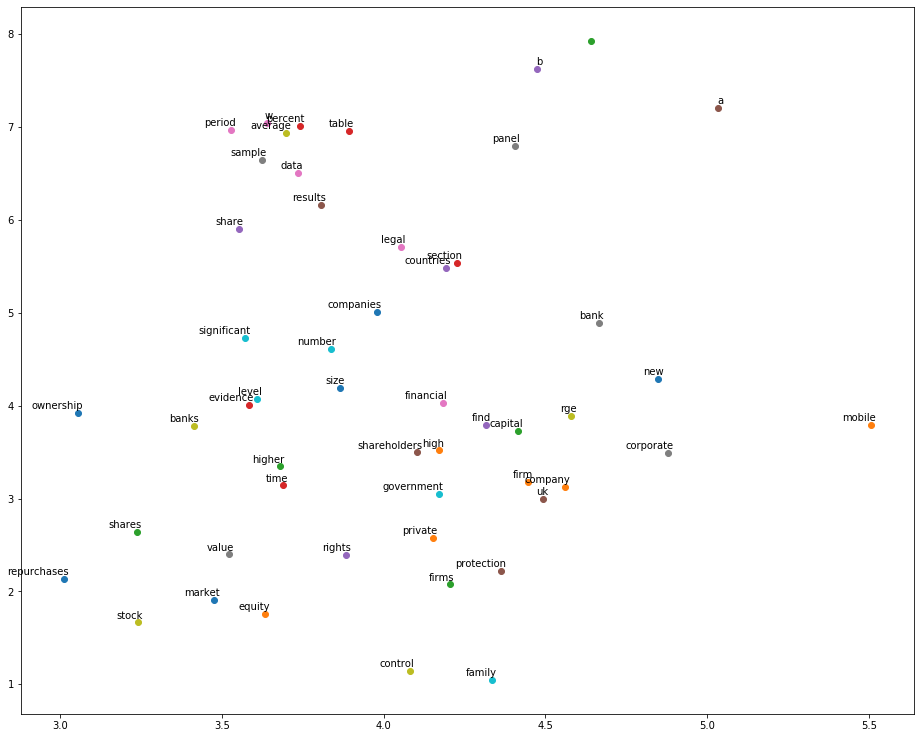

In [39]:
tsne_plot(selective_model)

In order to classify each scentance into the right prof based on our Word2Vec features, I would need to get the scentance level embeddings from each of the words present in each scentance. One strategy would be to **average out the word embeddings for each word in a scentance.**

In [77]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

temp_model = Word2Vec(sentances, size=250, window=30, min_count=1, workers=4, sample = 1e-3)

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=sentances, model=temp_model, num_features=250)
fa_df = pd.DataFrame(w2v_feature_array)
fa_df

/Users/ellafranks/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.398857,0.329638,0.195863,0.555313,-0.292698,0.009037,0.010689,-0.190527,0.524190,0.747515,...,-0.560822,0.310263,0.483500,0.166893,-0.150561,-0.240169,-0.541715,-0.489756,-0.554373,-0.651663
1,0.386117,0.506386,0.144398,0.752050,-0.308103,0.029566,-0.057108,-0.121475,0.619571,0.596998,...,-0.500308,0.322847,0.473672,0.101301,-0.244028,-0.179869,-0.419551,-0.424621,-0.410450,-0.636411
2,0.390229,0.557591,0.201803,0.837488,-0.385021,0.021515,-0.075195,-0.172140,0.610294,0.657662,...,-0.546144,0.357071,0.555320,0.091054,-0.295464,-0.219462,-0.484063,-0.417967,-0.394115,-0.616921
3,0.505304,0.359885,0.194426,0.444199,-0.310969,0.177233,0.076932,-0.214774,0.454414,0.761689,...,-0.592936,0.359374,0.625299,0.137736,-0.248559,-0.257792,-0.544549,-0.422424,-0.538852,-0.615836
4,0.385686,0.601859,0.176636,0.862792,-0.388378,0.047553,-0.088377,-0.151091,0.622166,0.606382,...,-0.529071,0.357236,0.552075,0.069305,-0.333639,-0.198934,-0.434423,-0.379765,-0.342671,-0.594333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24472,0.369288,0.137027,0.027452,0.332364,-0.209691,0.061513,0.033685,-0.072351,0.555096,0.719516,...,-0.565773,0.250925,0.276228,0.271011,-0.018519,-0.224451,-0.418376,-0.484058,-0.608585,-0.578509
24473,0.369288,0.137027,0.027452,0.332364,-0.209691,0.061513,0.033685,-0.072351,0.555096,0.719516,...,-0.565773,0.250925,0.276228,0.271011,-0.018519,-0.224451,-0.418376,-0.484058,-0.608585,-0.578509
24474,0.369288,0.137027,0.027452,0.332364,-0.209691,0.061513,0.033685,-0.072351,0.555096,0.719516,...,-0.565773,0.250925,0.276228,0.271011,-0.018519,-0.224451,-0.418376,-0.484058,-0.608585,-0.578509
24475,0.369288,0.137027,0.027452,0.332364,-0.209691,0.061513,0.033685,-0.072351,0.555096,0.719516,...,-0.565773,0.250925,0.276228,0.271011,-0.018519,-0.224451,-0.418376,-0.484058,-0.608585,-0.578509


**Now lets classify each scentance into the right prof based on our Word2Vec features.**

In [69]:
y = df2['prof'] 

In [85]:
X_trainw, X_testw, y_trainw, y_testw = train_test_split(fa_df, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

In [94]:
model = RandomForestClassifier()
model.fit(X_trainw, y_trainw)

/Users/ellafranks/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
predicted_w = model.predict(X_testw)
print("Random forest accuracy:",metrics.accuracy_score(y_testw, predicted_w))

Random forest accuracy: 0.7522467320261438


**We can see that the model peforms at**
- **75 percent accuracy based on 250 features vs 90 percent accuracy based on 5000 features.**

# Future directions

- Training my own custom domain specific corpus model with word2vec and gensim
- Recursive feature elimination 
- Optimise accuracy further, using grid search